In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import pandas as pd
from scipy.stats import beta, t, norm

%matplotlib inline


In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
n = 5000

In [12]:
np.random.seed(100)
x = np.float32(np.linspace(0,10,n))
error = np.random.standard_t(2,n)
y = 3*np.cos(x)-5*np.power((x/15),2)+error
y=np.float32(y)

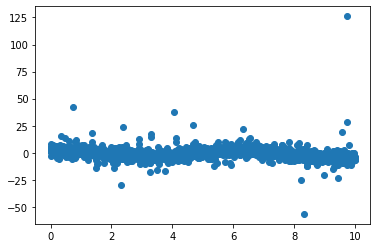

In [13]:
plt.scatter(x,y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [15]:
X = x.reshape(-1,1)
Y = y.reshape(-1,1)
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [16]:
X = torch.FloatTensor(X).to(device)
Y = torch.FloatTensor(Y).to(device)
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.FloatTensor(y_train).to(device)
y_test = torch.FloatTensor(y_test).to(device)

In [17]:
trainloader = DataLoader(X_train)
testloader = DataLoader(X_test)

In [18]:
class Model(nn.Module):
  '''
  one could probably get decent performance (even without a second optimization step) by setting the hidden layer configuration using just two rules: 
  (i) number of hidden layers equals one; and 
  (ii) the number of neurons in that layer is the mean of the neurons in the input and output layers.
  '''
  def __init__(self, in_features=1, h1=10, h2=10, out_features=1):
    super().__init__()
    self.fc1 = nn.Linear(in_features,h1)    # input layer
    self.fc2 = nn.Linear(h1, h2)            # hidden layer
    self.out = nn.Linear(h2, out_features)  # output layer
        
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)
    return x

  def training_step(self, x, y):
    pass

  def validation_step(self, x, y):
    pass
  
  def validation_epoch_end(self, outputs):
    pass
  
  def epoch_end(self, epoch, result):
    pass

In [19]:

class ModelTrainer():
  def fit(self, epochs=500, learning_rate=0.01, model=Model(),X_train=X_train,y_train=y_train,criterion = nn.MSELoss(), opt_func=torch.optim.Adam,seed=torch.manual_seed(4)):
    optimizer = opt_func(model.parameters(), learning_rate)

    for epoch in range(epochs):
        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss

  def _evaluate(self, model, X_test, y_test,criterion = nn.MSELoss()):
    with torch.no_grad():
      y_val = model.forward(X_test)
      loss = criterion(y_val, y_test)
    return [loss,y_val]



In [ ]:
best = []
for i in range(2,30):
  for j in range(2,30):
    model = Model(h1=i,h2=j).to(device)
    model_trainer = ModelTrainer()
    model_trainer.fit(500,0.01,model, X_train, y_train)
    best.append([i,j,model_trainer._evaluate(model,X_test,y_test)[0].to('cpu')])
  

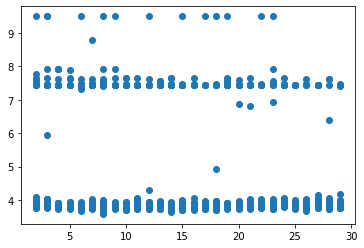

In [ ]:
plt.scatter(pd.DataFrame(best)[0],pd.DataFrame(best)[2],label='line1')

In [ ]:
pd.DataFrame(best)[(pd.DataFrame(best)[2]==min(pd.DataFrame(best)[2]))]

,0,1,2
195,8,29,tensor(3.5862)


In [ ]:
model = Model(h1=3,h2=29).to(device)
model_trainer = ModelTrainer()
model_trainer.fit(500,0.01,model, X_train, y_train)
y_val = model_trainer._evaluate(model,X,Y)[1]

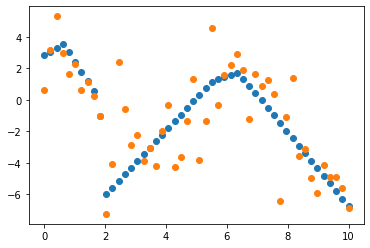

In [ ]:
plt.scatter(X.to('cpu'),y_val.to('cpu'),label='line1')
plt.scatter(X.to('cpu'),Y.to('cpu'),label='line2')

In [20]:
P,alpha = 0.99,0.05
for i in range(1,int(n/2)+1):
  if beta.cdf(P,n-2*i+1,2*i)>alpha: break
r = i-1 if i>1 else 1
B=1
x = np.float32(np.linspace(0,10,n))
y_true = 3*np.cos(x)-5*np.power((x/5),2)
interval = []
for i in range(B):
  x = np.float32(np.linspace(0,10,n))
  error = np.random.standard_normal(n)
  #error = np.random.standard_t(2,n)
  y = 3*np.cos(x)-5*np.power((x/5),2)  +error
  x = torch.FloatTensor(x.reshape(-1,1)).to(device)
  y = torch.FloatTensor(y.reshape(-1,1)).to(device)
  model = Model(h1=8,h2=29).to(device)
  model_trainer = ModelTrainer()
  model_trainer.fit(500,0.01,model, x, y)
  y_val = model_trainer._evaluate(model,x,y)[1]
  res =  y_val - y
  res = [res.to('cpu')[i] for i in range(n)]
  res.sort()
  L = res[r-1]
  U = res[n-r]
  interval_c = []
  for j in range(n):
    #interval_c.append(t.cdf((y_val[j] + U[0]).to('cpu'),df=2,loc=y_true[j])- t.cdf((y_val[j] + L[0]).to('cpu'),df=2,loc=y_true[j]))
    interval_c.append(norm.cdf((y_val[j] + U[0]).to('cpu'),loc=y_true[j])- norm.cdf((y_val[j] + L[0]).to('cpu'),loc=y_true[j]))
  interval.append(interval_c)
a=(pd.DataFrame(interval)>P).mean(axis=0)
a.to_csv('9599_500caseTI.csv')
print(sum((pd.DataFrame(interval)>P).sum(axis=0))/pd.DataFrame(interval).size , 'is 95/99 coverage probability for sample size 500')
'''
from google.colab import files
files.download('9590_500caseTI.csv')

b=(pd.DataFrame(interval)>0.99).mean(axis=0)
b.to_csv('9990_50caseTI.csv')
files.download('9990_50caseTI.csv')
print(sum((pd.DataFrame(interval)>0.95).sum(axis=0))/pd.DataFrame(interval).size , 'is 95/90 coverage probability for sample size 50')
print(sum((pd.DataFrame(interval)>0.99).sum(axis=0))/pd.DataFrame(interval).size , 'is 99/90 coverage probability for sample size 50')
'''

0.8014 is 95/99 coverage probability for sample size 500


"\nfrom google.colab import files\nfiles.download('9590_500caseTI.csv')\n\nb=(pd.DataFrame(interval)>0.99).mean(axis=0)\nb.to_csv('9990_50caseTI.csv')\nfiles.download('9990_50caseTI.csv')\nprint(sum((pd.DataFrame(interval)>0.95).sum(axis=0))/pd.DataFrame(interval).size , 'is 95/90 coverage probability for sample size 50')\nprint(sum((pd.DataFrame(interval)>0.99).sum(axis=0))/pd.DataFrame(interval).size , 'is 99/90 coverage probability for sample size 50')\n"

In [21]:
#a.to_csv('9590_500caseTI.csv')
from google.colab import files
files.download('9599_500caseTI.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
from google.colab import files
files.upload()

Saving 9599_500caseTI.csv to 9599_500caseTI.csv


{'9599_500caseTI.csv': b',0\n0,0.686\n1,0.692\n2,0.694\n3,0.696\n4,0.696\n5,0.704\n6,0.706\n7,0.712\n8,0.714\n9,0.718\n10,0.724\n11,0.728\n12,0.73\n13,0.73\n14,0.73\n15,0.732\n16,0.736\n17,0.734\n18,0.736\n19,0.738\n20,0.742\n21,0.746\n22,0.746\n23,0.754\n24,0.758\n25,0.758\n26,0.76\n27,0.762\n28,0.766\n29,0.766\n30,0.766\n31,0.766\n32,0.768\n33,0.768\n34,0.77\n35,0.776\n36,0.778\n37,0.784\n38,0.784\n39,0.79\n40,0.794\n41,0.796\n42,0.8\n43,0.8\n44,0.8\n45,0.802\n46,0.804\n47,0.806\n48,0.812\n49,0.816\n50,0.822\n51,0.828\n52,0.83\n53,0.83\n54,0.83\n55,0.83\n56,0.83\n57,0.834\n58,0.832\n59,0.832\n60,0.836\n61,0.84\n62,0.842\n63,0.846\n64,0.846\n65,0.848\n66,0.848\n67,0.85\n68,0.85\n69,0.85\n70,0.852\n71,0.852\n72,0.852\n73,0.854\n74,0.854\n75,0.854\n76,0.856\n77,0.856\n78,0.858\n79,0.86\n80,0.86\n81,0.862\n82,0.864\n83,0.866\n84,0.868\n85,0.872\n86,0.872\n87,0.874\n88,0.874\n89,0.876\n90,0.878\n91,0.88\n92,0.88\n93,0.88\n94,0.882\n95,0.88\n96,0.882\n97,0.884\n98,0.884\n99,0.886\n100,0.88

In [22]:
Upper, Lower = [], []
for j in range(n):
  Upper.append((y_val[j] + U[0]).to('cpu'))
  Lower.append((y_val[j] + L[0]).to('cpu'))

In [ ]:
print(sum((pd.DataFrame(interval)>0.9).sum(axis=0))/pd.DataFrame(interval).size , 'is 90/90 coverage probability for sample size 50')
print(sum((pd.DataFrame(interval)>0.95).sum(axis=0))/pd.DataFrame(interval).size , 'is 95/90 coverage probability for sample size 50')
print(sum((pd.DataFrame(interval)>0.99).sum(axis=0))/pd.DataFrame(interval).size , 'is 99/90 coverage probability for sample size 50')

0.9386484 is 90/90 coverage probability for sample size 50
0.7948052 is 95/90 coverage probability for sample size 50
0.141384 is 99/90 coverage probability for sample size 50


In [ ]:
n=500
for i in range(1,int(n/2)+1):
  if beta.cdf(0.99,n-2*i+1,2*i)>0.01: break
r = i-1 if i>1 else 1

In [3]:
#cov9095 = pd.read_csv('9590_500caseTI.csv')  
#cov9595 = pd.read_csv('9595_500caseTI.csv') 
cov9995 = pd.read_csv('9599_500caseTI.csv')  

Text(0.5, 1.0, 'Neural Network Performance')

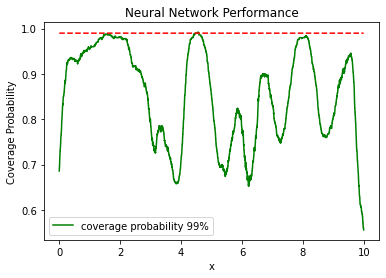

In [4]:
#plt.plot(cov9095.iloc[:,0]*0.02,cov9095.iloc[:,1],'k-',label='coverage probability 90%',color='blue')
#plt.plot(cov9095.iloc[:,0]*0.02,[0.90]*500,'k--',color='red',label='nominal confidence level')
#plt.plot(cov9595.iloc[:,0]*0.02,cov9595.iloc[:,1],'k-',label='coverage probability 95%')
#plt.plot(cov9595.iloc[:,0]*0.02,[0.95]*500,'k--',color='red')
plt.plot(cov9995.iloc[:,0]*0.002,cov9995.iloc[:,1],'k-',color='green',label='coverage probability 99%')
plt.plot(cov9995.iloc[:,0]*0.002,[0.99]*5000,'k--',color='red')
plt.legend()
plt.xlabel("x")
plt.ylabel("Coverage Probability")
plt.title('Neural Network Performance')

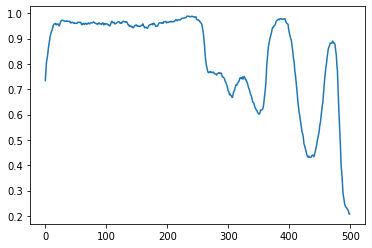

In [ ]:
plt.plot((pd.DataFrame(interval)>0.90).mean(axis=0))

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input obj

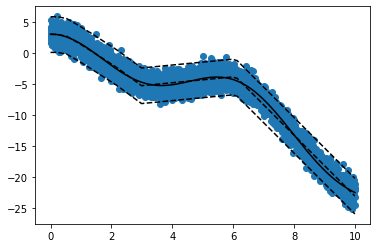

In [23]:
plt.scatter(x.to('cpu'),y.to('cpu'))
plt.plot(x.to('cpu'),y_true,'k-')
plt.plot(x.to('cpu'),y_val.to('cpu'),'k--')
plt.plot(x.to('cpu'),Upper,'k--')
plt.plot(x.to('cpu'),Lower,'k--')

In [ ]:
'''
test
epochs = 500
losses = []

for i in range(epochs):
    i+=1
    y_pred = model.forward(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%20 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
'''

In [ ]:
'''
test
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('epoch');
'''

In [ ]:
'''
gradient descend65
with torch.no_grad():
    y_val = model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')
'''